# Задача 3. Многоклассовая классификация и множественная классификация/регрессия
Мирошников Владислав Игоревич 471 группа (19.Б11)

## Задача

- [x] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [x] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [x] Замерить время обучения каждой модели для каждой стратегии.
- [x] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [x] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] * (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] * (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

В качестве датасета возьмем датасет с прошлой задачи Iris, так как он также подходит под задачу мульти-классовой классификации и имеет 3 класса.

In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# импорты
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
df, iris_y = load_iris(return_X_y=True, as_frame=True)
df['species'] = load_iris()['target']
df['species'] = df['species'].map({
    0: 'setosa',
    1: 'versicolor',
    2: 'virginica'
})
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Описание датасета

- Sepal Length - длина чашелистика
- Sepal Width - ширина чашелистика
- Petal Length - длина лепестка
- Petal Width - ширина лепестка
- Species - тип цветка

Будем решать задачу мультиклассовой классификации и предсказывать целевой признак **Species** и определять тип цветка.

In [3]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

Как видим, пропущенных значений нет.

## EDA

<AxesSubplot: xlabel='species', ylabel='count'>

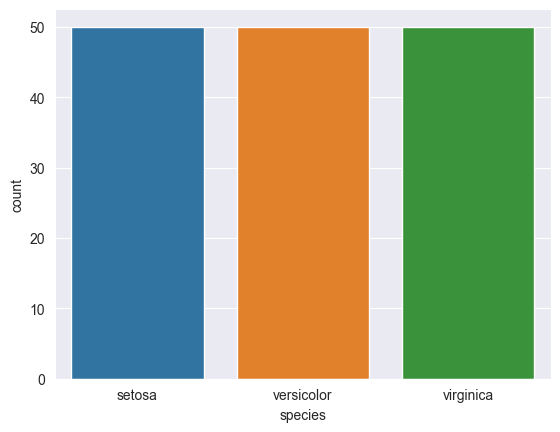

In [6]:
sns.countplot(x='species', data=df)

Видим, что у нас одинаково распределены типы цветков, по 50 цветков каждого вида.

<AxesSubplot: xlabel='species', ylabel='sepal length (cm)'>

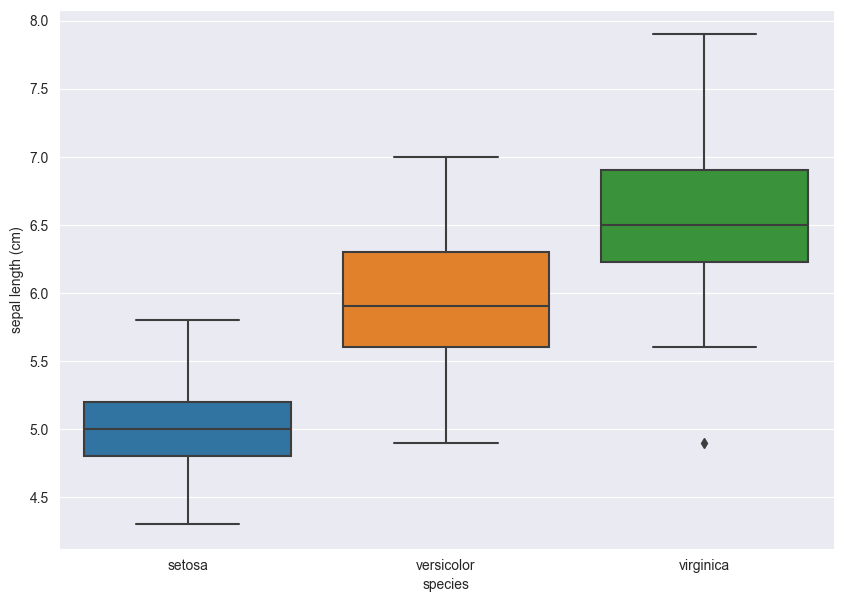

In [9]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='species', y='sepal length (cm)', data=df)

Видим, что тип цветка virginica имеет более длинную длину чашелистика в отличие от, например, setosa.

<AxesSubplot: xlabel='petal width (cm)', ylabel='petal length (cm)'>

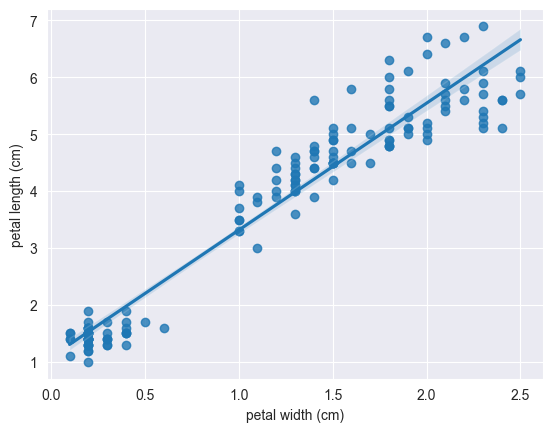

In [10]:
sns.regplot(x='petal width (cm)', y='petal length (cm)', data=df)

Можно заметить, что с увеличением ширины лепестка растет и его длина. Посмотрим на общие зависимости ширины/длины чашелистика и лепестка в зависимости от типа цветка.

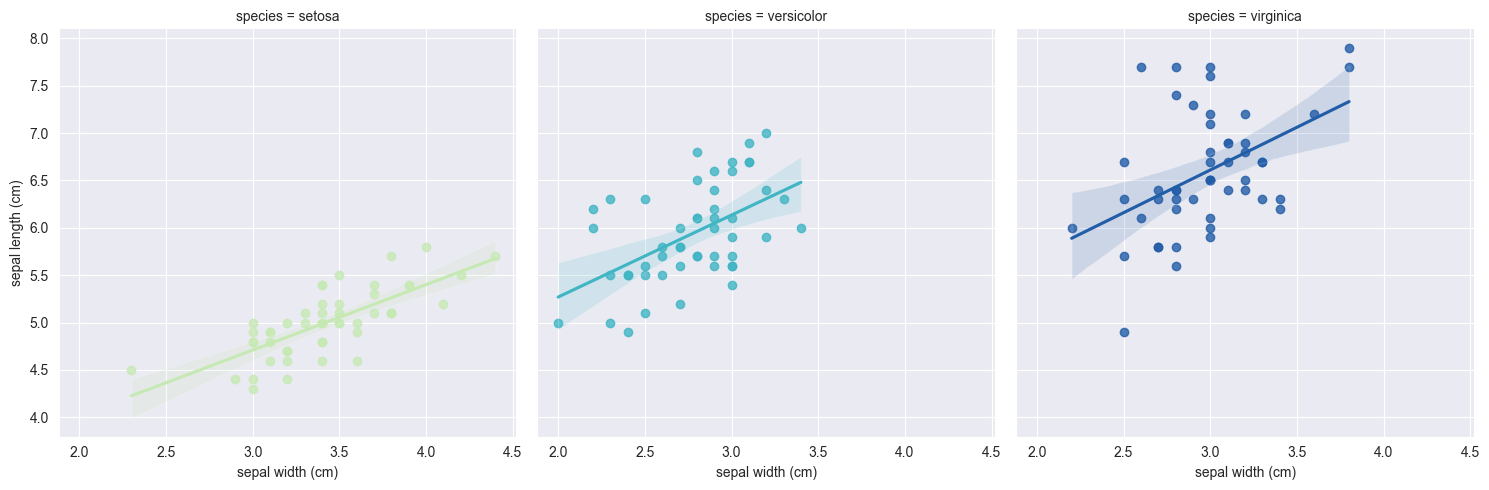

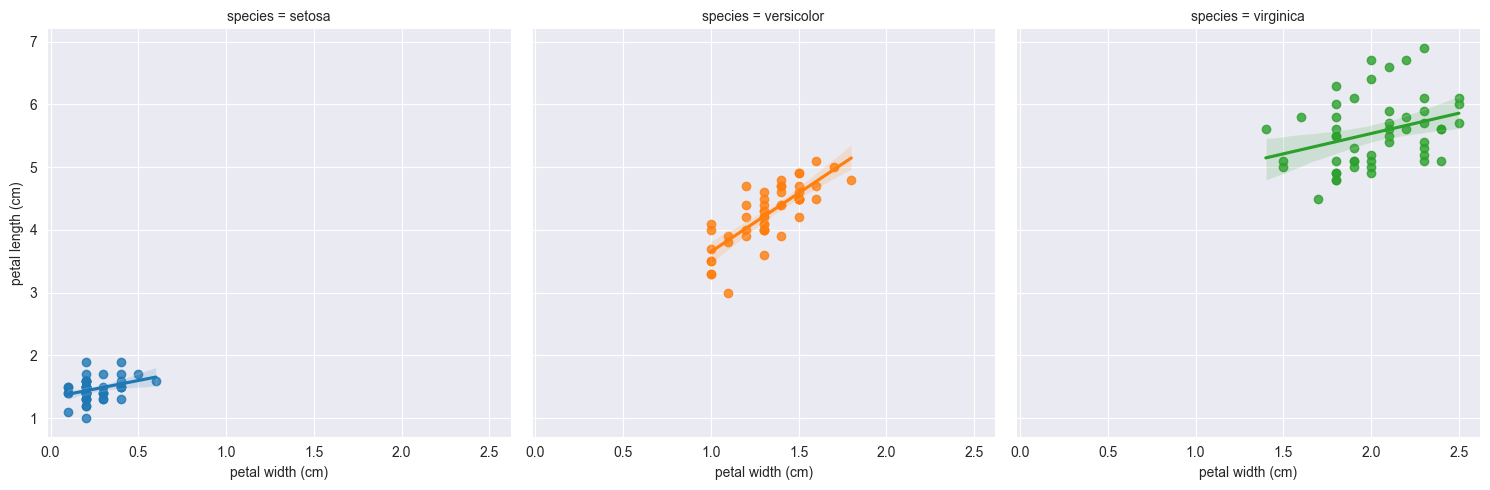

In [11]:
sns.lmplot(x='sepal width (cm)', y='sepal length (cm)', data=df, col='species', hue='species', palette='YlGnBu')
sns.lmplot(x='petal width (cm)', y='petal length (cm)', data=df, col='species', hue='species')

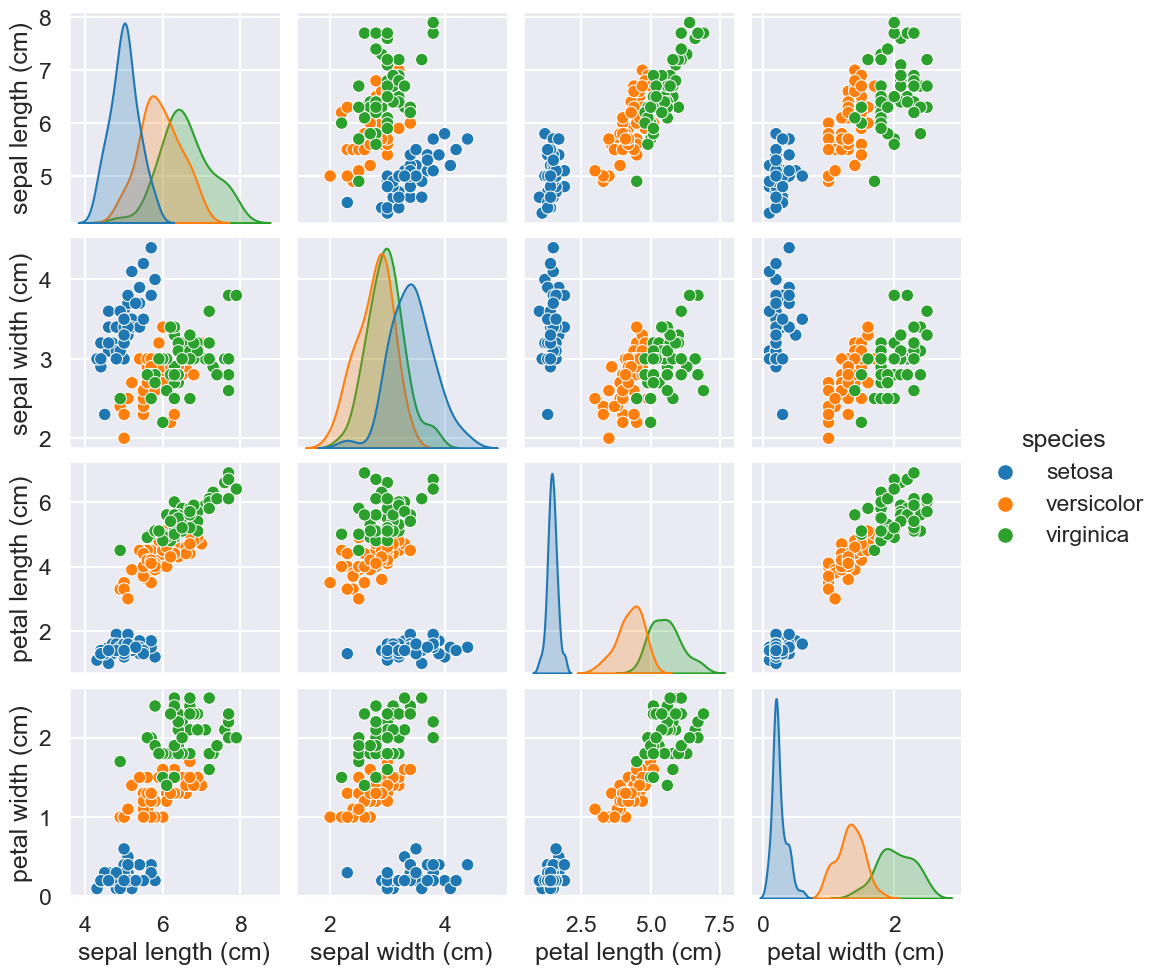

In [12]:
sns.set_context('talk')
sns.pairplot(df, hue='species')

По построенным графикам можно сделать следующие выводы:

- Тип цветка setosa достаточно сильно выделяется на фоне другие типов по ширине и длине лепестка. Так он имеет в разы меньший лепесток.
- Тип цветка setosa имеет большую ширину чашелистика и меньшую длину в сравнении с типом versicolor и verginica.
- Типы цветков versicolor и verginica во многом сходятся в размерах, однако если рассматривать граничные значения, то видно, что verginica имеет чуть большую длину чашелистика, а также чуть большую длину и ширину лепестка.

Будем учитывать это в дальнейшем, при этом можно заметить, что идентификации типа цветка setosa на основании размеров лепестка достаточно однозначна.

Преобразуем категориальный признак **species** и построим матрицу корреляции признаков друг с другом:

<AxesSubplot: >

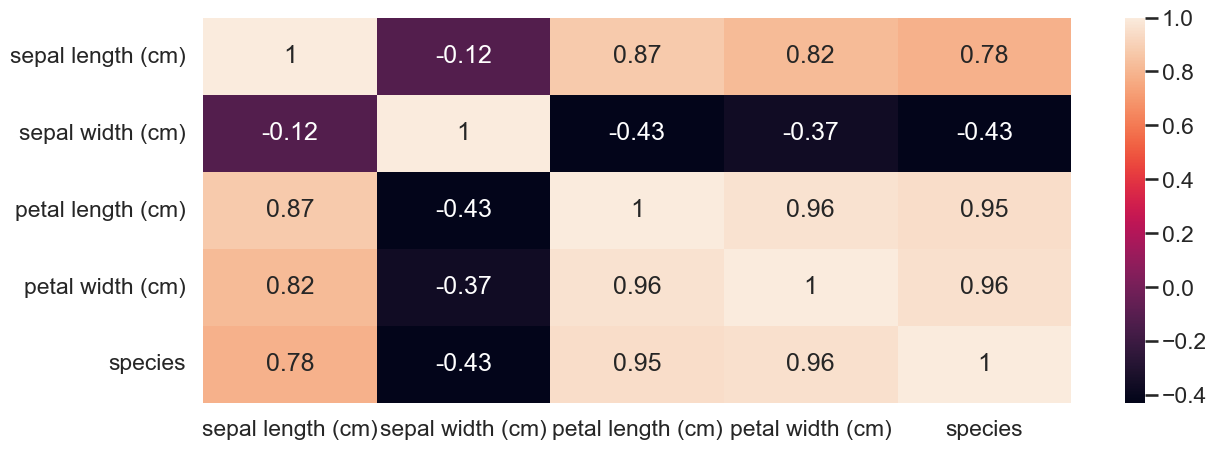

In [15]:
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])
plt.figure(figsize=(14, 5))
sns.heatmap(df.corr(), annot=True)

Как можно заметить, у нас наблюдается достаточно сильная корреляция всех признаков друг с другом.

## Разбиение данных на обучающую и тестовую выборки

In [17]:
x = df.drop(['species'], axis=1)
y = df['species']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

Используем также масштабирование данных:

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Recursive Feature Elimination (RFE)

Подберем наилучшее количество признаков и оставим только их.

Оптимальное число признаков: 2
Выбранные признаки: ['petal length (cm)', 'petal width (cm)']


C:\mlvenv\venv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


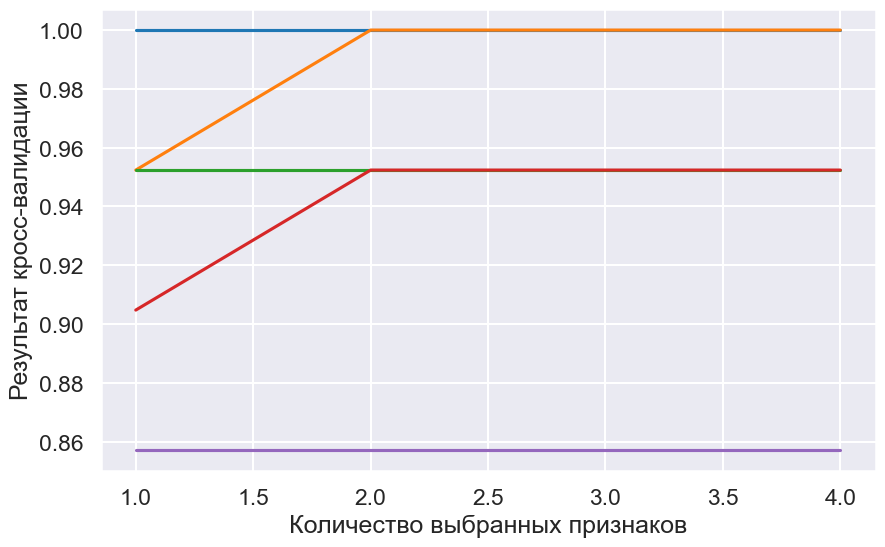

In [19]:
rfecv = RFECV(estimator=LogisticRegression(), cv=5)
rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train.columns[rfecv.support_])

print(f"Оптимальное число признаков: {rfecv.n_features_}")
print(f'Выбранные признаки: {selected_features}')

plt.figure(figsize=(10, 6))
plt.xlabel("Количество выбранных признаков")
plt.ylabel("Результат кросс-валидации")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Уберем лишние признаки:

In [20]:
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x.columns)
selected_features = list(x_train_scaled_df.columns[rfecv.support_])
x_train_scaled = x_train_scaled_df[selected_features].to_numpy()
x_test_scaled = x_test_scaled_df[selected_features].to_numpy()

## Подбор гиперпараметров модели

Подберем оптимальные гиперпараметры для библиотечных моделей и будем их использовать в дальнейшем при обучении моделей.

## Logistic Regression

In [22]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
log_reg_searcher = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring="roc_auc_ovr",
                                error_score="raise",
                                cv=5, )
log_reg_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(log_reg_searcher.best_estimator_))
print("Best params: " + str(log_reg_searcher.best_params_))

Best estimator: LogisticRegression(C=0.40001000000000003)
Best params: {'C': 0.40001000000000003}


## SVM

In [29]:
C = [0.1, 0.2, 0.5, 1, 2, 5]
kernel = ["linear", "poly", "rbf"]
gamma = [0.001, 0.01, 0.1, 1, "scale", "auto"]

svc_searcher = GridSearchCV(estimator=SVC(random_state=50, probability=True), scoring="roc_auc_ovr",
                            cv=5,
                            error_score="raise",
                            param_grid=dict(kernel=kernel, C=C, gamma=gamma))
svc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: ", str(svc_searcher.best_estimator_))
print("Best params: ", str(svc_searcher.best_params_))

Best estimator:  SVC(C=0.1, gamma=0.001, kernel='linear', probability=True, random_state=50)
Best params:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}


## KNN

In [24]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree']

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=7)
knn_searcher = GridSearchCV(estimator=KNeighborsClassifier(), scoring="roc_auc_ovr", cv=5,
                            error_score="raise",
                            param_grid=dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm))
knn_searcher.fit(x_train_scaled, y_train)

print("Best estimator: " + str(knn_searcher.best_estimator_))
print("Best params: " + str(knn_searcher.best_params_))

Best estimator: KNeighborsClassifier(n_neighbors=7)
Best params: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}


## Naive Bayes

In [30]:
var_smoothing = np.logspace(0, -9)

rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=18)
nb_searcher = GridSearchCV(estimator=GaussianNB(), scoring="roc_auc_ovr",
                           cv=5,
                           error_score="raise",
                           param_grid=dict(var_smoothing=var_smoothing))
nb_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(nb_searcher.best_estimator_))
print("Best params: " + str(nb_searcher.best_params_))

Best estimator: GaussianNB(var_smoothing=1.0)
Best params: {'var_smoothing': 1.0}


## Decision Tree

In [26]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [1, 2]

dtc_searcher = GridSearchCV(estimator=DecisionTreeClassifier(random_state=14), scoring="roc_auc_ovr",
                            cv=5, error_score="raise",
                            param_grid=dict(criterion=criterion, splitter=splitter, max_depth=max_depth,
                                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                            max_features=max_features))
dtc_searcher.fit(x_train_scaled, y_train)
print("Best estimator: " + str(dtc_searcher.best_estimator_))
print("Best params: " + str(dtc_searcher.best_params_))

Best estimator: DecisionTreeClassifier(max_depth=4, max_features=1, min_samples_leaf=6,
                       random_state=14)
Best params: {'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 2, 'splitter': 'best'}


## Обучение моделей и сравнения

Проведем обучения моделей при разных стратегиях и сравним их, используя для каждой модели подобранные гиперпараметры:

Создадим также разные классификаторы:

In [34]:
lr_classifier = LogisticRegression(C=log_reg_searcher.best_params_["C"])
svm_classifier = SVC(C=svc_searcher.best_params_["C"], kernel=svc_searcher.best_params_["kernel"], gamma=svc_searcher.best_params_["gamma"], random_state=50, probability=True)
knn_classifier = KNeighborsClassifier(n_neighbors=knn_searcher.best_params_["n_neighbors"],
                     algorithm=knn_searcher.best_params_["algorithm"],
                     weights=knn_searcher.best_params_["weights"])
naive_bayes_classifier = GaussianNB(var_smoothing=nb_searcher.best_params_["var_smoothing"])
dt_classifier = DecisionTreeClassifier(criterion=dtc_searcher.best_params_["criterion"],
                                       splitter=dtc_searcher.best_params_["splitter"],
                                       max_depth=dtc_searcher.best_params_["max_depth"],
                                       min_samples_split=dtc_searcher.best_params_["min_samples_split"],
                                       min_samples_leaf=dtc_searcher.best_params_["min_samples_leaf"],
                                       max_features=dtc_searcher.best_params_["max_features"])

In [35]:
accuracies = {}
times = {}

def time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()

## OneVsRest
### Logistic Regression

In [36]:
lr_one_vs_rest = OneVsRestClassifier(lr_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, lr_one_vs_rest.predict(x_test_scaled))
accuracies["LR_OVR"] = acc
times["LR_OVR"] = time(lr_one_vs_rest, x_train_scaled , y_train)

### SVM

In [37]:
svm_one_vs_rest = OneVsRestClassifier(svm_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, svm_one_vs_rest.predict(x_test_scaled))
accuracies["SVM_OVR"] = acc
times["SVM_OVR"] = time(svm_one_vs_rest, x_train_scaled , y_train)

### KNN

In [38]:
knn_one_vs_rest = OneVsRestClassifier(knn_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, knn_one_vs_rest.predict(x_test_scaled))
accuracies["KNN_OVR"] = acc
times["KNN_OVR"] = time(knn_one_vs_rest, x_train_scaled , y_train)

### Naive Bayes

In [39]:
nb_one_vs_rest = OneVsRestClassifier(naive_bayes_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, nb_one_vs_rest.predict(x_test_scaled))
accuracies["NB_OVR"] = acc
times["NB_OVR"] = time(nb_one_vs_rest, x_train_scaled , y_train)

### Decision Tree

In [40]:
dt_one_vs_rest = OneVsRestClassifier(dt_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, dt_one_vs_rest.predict(x_test_scaled))
accuracies["DT_OVR"] = acc
times["DT_OVR"] = time(dt_one_vs_rest, x_train_scaled , y_train)

## OneVsOne

### Logistic Regression

In [41]:
lr_one_vs_one = OneVsOneClassifier(lr_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, lr_one_vs_one.predict(x_test_scaled))
accuracies["LR_OVO"] = acc
times["LR_OVO"] = time(lr_one_vs_one, x_train_scaled , y_train)

### SVM

In [42]:
svm_one_vs_one = OneVsOneClassifier(svm_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, svm_one_vs_one.predict(x_test_scaled))
accuracies["SVM_OVO"] = acc
times["SVM_OVO"] = time(svm_one_vs_one, x_train_scaled , y_train)

### KNN

In [43]:
knn_one_vs_one = OneVsOneClassifier(knn_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, knn_one_vs_one.predict(x_test_scaled))
accuracies["KNN_OVO"] = acc
times["KNN_OVO"] = time(knn_one_vs_one, x_train_scaled , y_train)

### Naive Bayes

In [44]:
nb_one_vs_one = OneVsOneClassifier(naive_bayes_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, nb_one_vs_one.predict(x_test_scaled))
accuracies["NB_OVO"] = acc
times["NB_OVO"] = time(nb_one_vs_one, x_train_scaled , y_train)

### Decision Tree

In [45]:
dt_one_vs_one = OneVsOneClassifier(dt_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, dt_one_vs_one.predict(x_test_scaled))
accuracies["DT_OVO"] = acc
times["DT_OVO"] = time(dt_one_vs_one, x_train_scaled , y_train)

## Output Code

### Logistic Regression

In [46]:
lr_output = OutputCodeClassifier(lr_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, lr_output.predict(x_test_scaled))
accuracies["LR_OC"] = acc
times["LR_OC"] = time(lr_output, x_train_scaled , y_train)

### SVM

In [47]:
svm_output = OutputCodeClassifier(svm_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, svm_output.predict(x_test_scaled))
accuracies["SVM_OC"] = acc
times["SVM_OC"] = time(svm_output, x_train_scaled , y_train)

### KNN

In [48]:
knn_output = OutputCodeClassifier(knn_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, knn_output.predict(x_test_scaled))
accuracies["KNN_OC"] = acc
times["KNN_OC"] = time(knn_output, x_train_scaled , y_train)

### Naive Bayes

In [49]:
nb_output = OutputCodeClassifier(naive_bayes_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, nb_output.predict(x_test_scaled))
accuracies["NB_OC"] = acc
times["NB_OC"] = time(nb_output, x_train_scaled , y_train)

### Decision Tree

In [50]:
dt_output = OutputCodeClassifier(dt_classifier).fit(x_train_scaled, y_train)
acc = accuracy_score(y_test, dt_output.predict(x_test_scaled))
accuracies["DT_OC"] = acc
times["DT_OC"] = time(dt_output, x_train_scaled , y_train)

## Сравнение

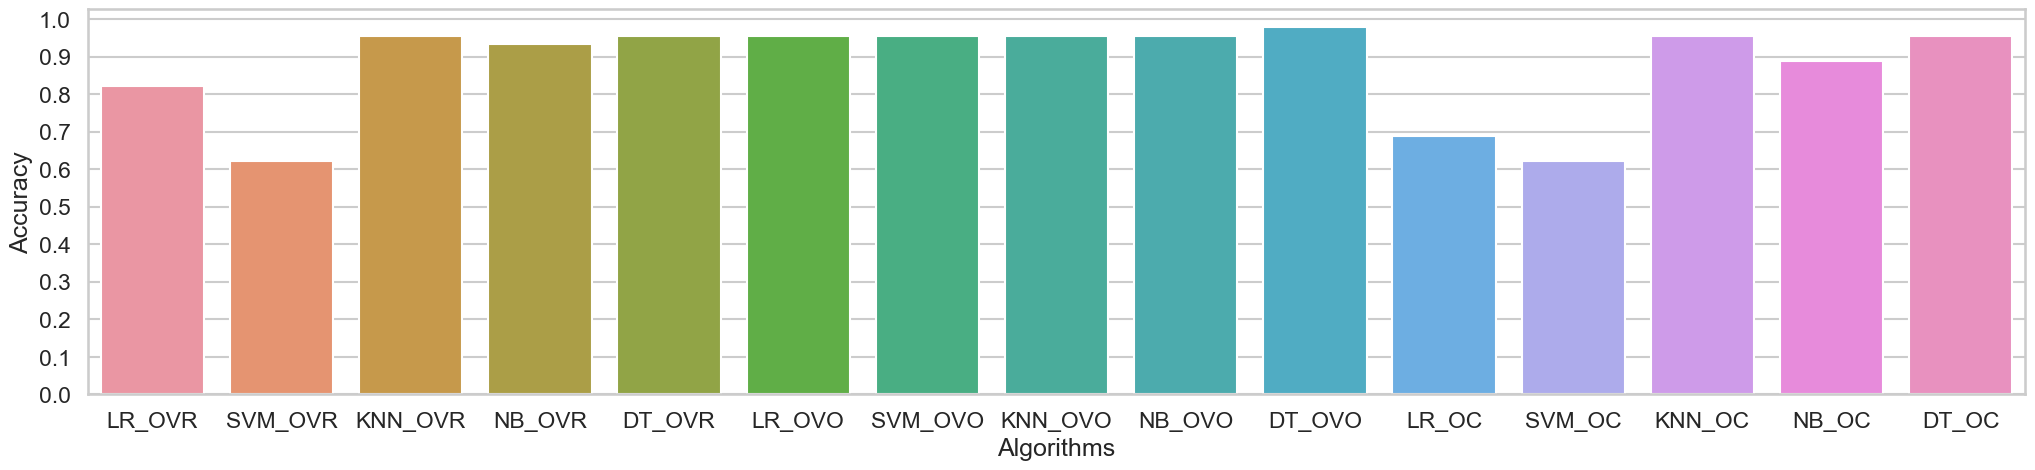

In [52]:
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

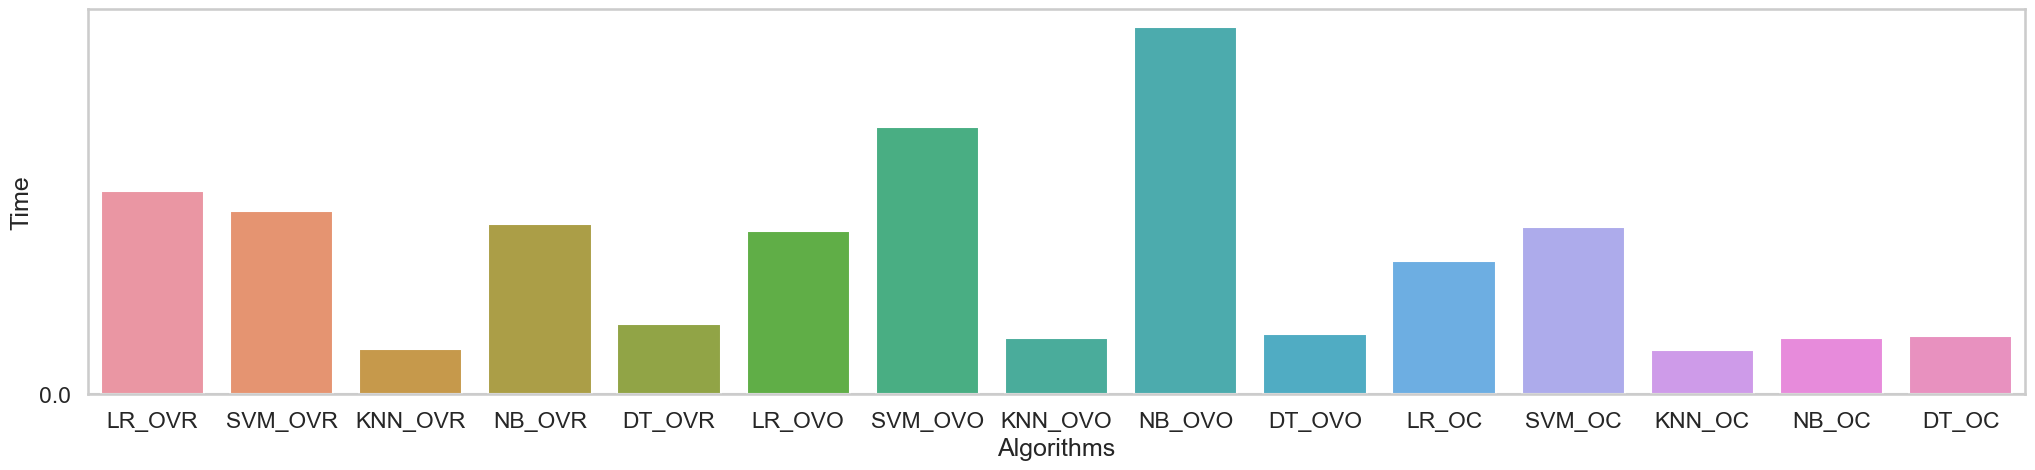

In [53]:
sns.set_style("whitegrid")
plt.figure(figsize=(25, 5))
plt.yticks(np.arange(0, 5, 0.1))
plt.ylabel("Time")
plt.xlabel("Algorithms")
sns.barplot(x=list(times.keys()), y=list(times.values()))
plt.show()

Выводы:
- Как мы видим, на датасете Iris для решения задачи мультиклассовой классификации лучше всего с точки зрения accuracy среди всех классификаторов (LR, SVM, KNN, NB, DT) показала себя стратегия OneVsOne.
- Стратегии OneVsRest и OutputCode по accuracy показывают примерно одинаковые значения.
- Наименьшую точность среди всех стратегий и классификаторов имеет SVM_OVR и SVM_OC.
- Худшее время показывают NB_OVO и SVM_OVO.